In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

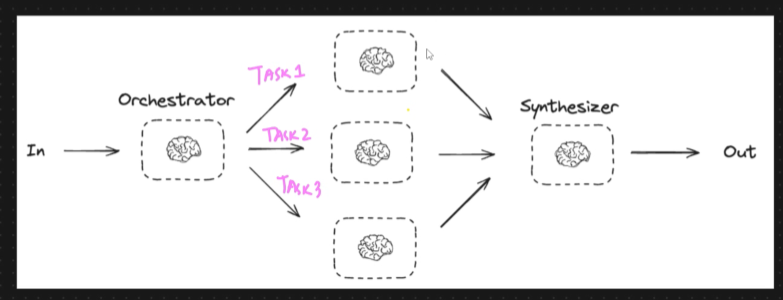

### **High-Level Summary**

Building an **Agentic Workflow** that:

1. **Takes a topic** like `"Agentic AI RAGs"`.
2. **Breaks it into meaningful sections** (like "Overview", "Benefits", "Use Cases").
3. **Assigns one worker per section**, each writing its part of the report **independently and in parallel**.
4. **Collects all completed sections**.
5. **Combines them into one final, formatted report**.

Think of it like a team of AI writers working together:
🧑‍🏫 The manager (orchestrator) decides who writes what.
✍️ Each writer (worker) handles their own section.
🧾 The editor (synthesizer) puts it all together neatly.

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
llm=ChatGroq(model="qwen-qwq-32b")
result=llm.invoke("Hello")
result

AIMessage(content='\n<think>\nOkay, the user said "Hello". I need to respond appropriately. Let me start with a friendly greeting. I should ask how I can assist them today. Maybe add an emoji to keep it warm. Let me check for any typos. Alright, that should work.\n\nWait, maybe I can make it a bit more personal. Instead of just "Hello! How can I assist you today?", perhaps include their name if possible. But since they didn\'t provide a name, maybe stick to the original. Or use "there" instead of "you"? Hmm, the original is good. I\'ll go with that.\n</think>\n\nHello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 139, 'prompt_tokens': 11, 'total_tokens': 150, 'completion_time': 0.315840204, 'prompt_time': 0.002732668, 'queue_time': 0.263625392, 'total_time': 0.318572872}, 'model_name': 'qwen-qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'stop', 'logprobs': None}, id='run-fabe7bfc-8672-40bf-bf7c-186d0b6

In [8]:
from typing import Annotated, List
import operator
# The import operator statement imports Python’s built-in operator module, which provides efficient, 
# function-based equivalents for many standard operators (like +, -, *, etc.).
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict

In [14]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

### Creating Workers Dynamically In Langgraph 
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [15]:
from langgraph.constants import Send

# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    
    # LangGraph reads this annotation and, when collecting results from parallel workers,
    # automatically concatenates all their completed_sections lists into one.
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]
    

In [16]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""
    
    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate the plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}")
        ]
    )
    
    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""
    
    # Generate Section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            )
        ]
    )
    
    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    
    # Kick off section writing in parallel via Send() API
    return[Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""
    
    # List of completed sections
    completed_sections = state["completed_sections"]
    
    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    
    return {"final_report": completed_report_sections}
    

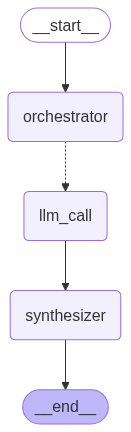

In [18]:
# Build workflow
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [19]:
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])


<think>
Okay, so the user wants me to write the Introduction section of a report about Agentic AI RAGs. The name of the section is "Introduction" and the description says it should cover the purpose, scope, and relevance of exploring Agentic AI RAGs in modern AI systems. Alright, first I need to make sure I understand what Agentic AI RAGs are. Wait, RAG stands for Retrieve-Aggregate-Generate, right? So Agentic AI RAGs probably refer to systems that combine retrieval, aggregation, and generation with some form of agency, maybe autonomous decision-making or goal-directed behavior. 

The user mentioned "no preamble," so I should jump right into the section without any introductory sentences. The section needs to clearly state the purpose of the report, which is to explore the role of Agentic AI RAGs in modern AI systems. The scope might involve discussing their components, applications, and implications. The relevance would be why this matters now, like how these systems are crucial for advanced applications in various sectors.

I should start by defining Agentic AI RAGs to set the context. Then explain their components: retrieval of data, aggregation of information, and generation of outputs. But with the twist of agency, which allows them to operate more autonomously. 

Next, the purpose of the report is to analyze how these components work together and their impact. The scope would include examining current implementations, challenges, and future directions. The relevance part needs to tie into real-world applications, like improving decision-making in healthcare, enhancing customer support, or automating content creation. It's also important to mention the growing significance of these systems in addressing complex tasks where traditional methods fall short.

I need to make sure the language is formal but clear, using markdown formatting as specified. Since there's no preamble, I shouldn't add any extra sections or headings beyond the given one. Also, check that all key points from the description are covered. Maybe structure it in a few paragraphs: first paragraph introducing the concept and purpose, the second covering scope, and the third relevance. Alternatively, combine scope and purpose in one paragraph and relevance in another. Let me make sure each required element is addressed succinctly without fluff. 

Hmm, are there any potential challenges or ethical considerations that should be hinted at in the introduction? The user didn't specify, so maybe just stick to the given points. The report's purpose is to explore their role, scope is the analysis of components, applications, and implications, and relevance is their importance in modern AI systems. Okay, that should do it. Let me put this together in markdown, starting with the section header, then the content as per the structure.
</think>

# Introduction  

This report examines the role of Agentic AI Retrieval-Augmented Generation (RAG) systems in modern AI architectures, focusing on their structure, capabilities, and implications for current and future AI applications. The purpose of this analysis is to clarify how these systems integrate autonomous decision-making (agency) with data retrieval, synthesis, and output generation, enabling more contextualized and adaptive responses.  

The scope of the report spans technical components of Agentic AI RAGs—such as dynamic query formulation, context-aware data selection, and iterative refinement—alongside their applications in fields like customer service, content creation, and expert systems. It also evaluates challenges, including ethical considerations, reliability, and scalability, to provide a balanced assessment of their potential.  

The relevance of exploring Agentic AI RAGs lies in their ability to address limitations of static or rule-based systems by introducing flexibility and responsiveness. As AI systems increasingly require contextual understanding and proactive problem-solving, agentic RAGs represent a critical advancement toward robust, human-like intelligence in automated systems. This exploration is timely given the growing demand for AI solutions that navigate ambiguity, adapt to evolving user needs, and operate in unstructured real-world environments.

---


<think>
Okay, I need to write a report section called "Key Concepts" that includes definitions of Agentic AI and RAG. Let me start by recalling what each term means.

Agentic AI refers to systems that can act autonomously, right? They have their own goals and can make decisions without constant human input. I should mention autonomy and goal-driven behavior. Maybe also note that they can adapt and learn, which differentiates them from traditional systems that follow fixed rules.

Now, RAG stands for Retrieve, Analyze, Generate frameworks. I remember that RAG is used in NLP, especially with large language models. The retrieve part is getting data from sources, analyze involves understanding that data, and generate is creating a response. I should break down each step clearly. Also, it's important to highlight why RAG is useful—like improving accuracy and context awareness.

Wait, should I mention examples or use cases? The user didn't ask for that, just definitions. So keep it to the essentials. Also, structure each term in bold with a colon, as per the example. Make sure to use markdown formatting without any extra sections or preambles. Just the two definitions under the Key Concepts header. Let me check the example response again to match the structure. Yeah, bullet points with bold terms. Alright, time to put it all together concisely.
</think>

**Key Concepts**  

- **Agentic AI (Autonomous Goal-Driven Systems)**  
  Agentic AI refers to artificial intelligence systems designed to operate with autonomy, equipped with intrinsic goals, decision-making capabilities, and the ability to act in environments to achieve those goals. These systems independently perceive their surroundings, prioritize objectives, and adapt behaviors without continuous human intervention, distinguishing them from purely reactive or rule-based AI.  

- **RAG (Retrieve, Analyze, Generate Frameworks)**  
  RAG denotes a modular framework commonly used in AI applications, particularly in natural language processing (NLP). It involves three core steps:  
  1. **Retrieve**: Extracting relevant data or information from a database, corpus, or external sources.  
  2. **Analyze**: Interpreting and processing the retrieved data to identify patterns, context, or insights.  
  3. **Generate**: Creating a coherent, context-aware output (e.g., text, code, or responses) based on the analyzed data.  
  This framework enhances AI systems' ability to contextualize information and produce dynamic, informed outputs.

---


<think>
Okay, I need to write a report section titled "Agentic AI Fundamentals" based on the user's description. The description mentions explaining agentic AI principles, autonomy, decision-making processes, and goal-oriented behavior. Let me start by breaking down each component.

First, the introduction part. The user wants an explanation of the principles of agentic AI. I should define what agentic AI is. Maybe start by saying it's a type of AI designed to act as an autonomous agent, pursuing specific goals. I should mention that it's inspired by the concept of agency in philosophy, which is the capacity to act independently and make free choices. That connects the philosophical idea to the AI concept.

Next, autonomy. The user wants to cover autonomy, so I need to explain how agentic AI operates without constant human intervention. I should talk about decision-making autonomy, where the AI can choose actions based on its objectives. Also, contextual autonomy is important—adapting to changing environments. Maybe mention that autonomy is constrained by ethical and safety boundaries to prevent unintended consequences.

Then, decision-making processes. Here, I need to outline how agentic AI makes decisions. Start with goal prioritization: the AI evaluates which goals are more important. Then, environmental analysis—using sensors or data to understand the current situation. Action selection involves choosing the best course of action, maybe using algorithms like reinforcement learning or decision trees. Iterative refinement is important too, where the AI updates its strategies based on outcomes. I should mention real-time adaptation for dynamic environments.

Goal-oriented behavior is next. The section should explain how agentic AI is designed with clear objectives. Primary goals are the main objectives, while secondary goals support them. There's also value alignment, ensuring goals align with human values. Maybe give an example, like an AI managing a smart home with energy efficiency as a primary goal.

I should also include a section on challenges. Ethical implications are crucial—ensuring the AI doesn't act against human interests. Technical limitations might involve complexity in dynamic environments. Safety and control mechanisms need to be emphasized to prevent errors.

Wait, the user said to include no preamble, so each section should start directly. The example given by the assistant in the previous response used headers like "Principles of Agentic AI" under the main section. The user wants markdown formatting, so I'll structure each sub-section with headers.

Let me check the user's example again. In their answer, they had the main section with subheadings. The user's instruction says "Include no preamble for each section," which probably means don't have an introductory paragraph before starting the subpoints. So I can start the section right away with the subheadings as per the description.

Wait, but the user's instruction was to "Include no preamble for each section," so maybe each section should start immediately without an introductory paragraph. The example they provided did have some paragraphs under each subheading, so I should structure it similarly. Let me make sure each subsection is concise but covers the key points without fluff.

I need to ensure that all parts of the description are addressed: principles, autonomy, decision-making, goal-oriented behavior, and perhaps challenges. The user's example included challenges, so I should include that as well.

Let me start drafting each part. For the principles, explain what agentic AI is and its core aspects. Autonomy needs to explain both decision-making and contextual autonomy. Decision-making processes should detail the steps the AI takes. Goal-oriented behavior should explain how goals are structured and aligned. Challenges should touch on ethics, technical issues, and safety.

I should use clear, concise points. Also, use examples where possible, like the smart home example for goal-oriented behavior. Ensure that each section is in markdown with appropriate headers. Let me check for any missing parts. The user's example included "Ethical and Safety Considerations" under challenges, so that's good.

I need to avoid any markdown formatting here since I'm just planning, but in the actual answer, I'll use headers. Let me make sure that each section flows logically. Start with principles, then autonomy (since autonomy is part of the principles?), maybe structure them as separate subsections. Wait, in the example, "Principles of Agentic AI" is a subsection under the main section. The user's example structure is:

# Agentic AI Fundamentals

## Principles of Agentic AI

So I need to follow that structure. Let me ensure each of the user's points is covered in the subsections. Principles would introduce the concept. Autonomy is a subsection, decision-making processes another, goal-oriented behavior another, and challenges. That should cover all the points from the description.

I think that's all. Now, time to put it all together in markdown format without any extra text, just the sections as specified.
</think>

# Agentic AI Fundamentals  

## Principles of Agentic AI  
Agentic AI refers to systems designed to exhibit agency, the ability to act purposefully within an environment to achieve defined objectives. These systems operate based on core principles, including **goal-directed behavior**, **autonomous decision-making**, and **adaptation to dynamic contexts**. Unlike passive or reactive systems, agentic AI continuously evaluates options, predicts outcomes, and selects actions to optimize progress toward its goals.  

## Autonomy  
Agentic AI achieves autonomy through **decision-making independence** and **operational flexibility**. It operates without direct human intervention, relying on internal models and external sensor data to assess situations. Autonomy includes:  
- **Decision-making autonomy**: The AI selects actions aligned with its programmed objectives.  
- **Contextual autonomy**: The system adapts its behavior in response to environmental changes or unexpected events.  
Autonomy is constrained by ethical, legal, or safety boundaries to prevent harmful or unintended outcomes.  

## Decision-Making Processes  
Agentic AI employs structured processes to resolve complex scenarios:  
1. **Goal Prioritization**: Identifies and ranks objectives based on urgency, importance, or user-defined criteria.  
2. **Environmental Analysis**: Uses sensors, data streams, or simulations to understand the current state of the environment.  
3. **Action Selection**: Applies algorithms (e.g., reinforcement learning, Bayesian reasoning) to choose the optimal action sequence.  
4. **Iterative Refinement**: Continuously revises strategies based on feedback from outcomes, forming a loop of "sense, decide, act, evaluate."  

## Goal-Oriented Behavior  
Agentic AI is fundamentally driven by goals, which are embedded through:  
- **Primary Goals**: Core objectives (e.g., maximizing efficiency, minimizing costs).  
- **Secondary Goals**: Sub-objectives that support primary goals (e.g., maintaining system integrity).  
- **Value Alignment**: Ensuring goals align with human values to avoid misalignment risks (e.g., unintended consequences from narrow optimization).  

## Challenges and Considerations  
While agentic AI offers significant potential, challenges persist:  
- **Ethical Dilemmas**: Balancing autonomy with accountability for decisions.  
- **Technical Complexity**: Ensuring robustness in unpredictable environments.  
- **Safety and Control**: Implementing safeguards to prevent harmful outcomes, such as "goal corruption" or "infinite loop" scenarios.  

These principles and challenges define the framework for developing agentic AI systems that are both capable and responsible.

---


<think>
Okay, I need to write a report section titled "RAG Framework Overview" based on the user's description. The description says to break down RAG systems into three parts: retrieval of external data, analysis via models, and generation of contextual responses. Let me start by recalling what RAG stands for. RAG is Retrieve-and-Generate, right? It's a common approach in large language models to enhance their responses by incorporating external data.

First, the section should have an introduction that briefly explains what the RAG framework is. Then, I need to split it into the three components as specified. Let me structure each part step by step.

Starting with the first component: retrieval of external data. I should explain how RAG systems retrieve data from external sources. Maybe mention that they use vector databases or search engines to find relevant documents. Also, it's important to note that this retrieval is based on the user's query, so the system compares the query embeddings with those in the database.

Next is the analysis via models part. Here, the retrieved data needs to be processed. The models, which could be LLMs or other types, analyze the data to extract relevant information. Maybe mention techniques like filtering or summarizing the data to make it usable for the next step. Also, the analysis ensures that the data is accurate and contextually relevant, which helps in generating better responses.

The third part is the generation of contextual responses. The models take the analyzed data and combine it with their own training data to create a coherent response. It's important to highlight that the generated response should be both accurate and contextually appropriate, using the external data to provide more informed answers.

I should also think about linking these components together to show how they form a cohesive system. Maybe conclude with a sentence on the benefits of RAG, like improved accuracy and up-to-date information. Wait, does the user want me to include benefits? The description doesn't mention that, but a brief mention in the conclusion part might be okay as long as it's concise.

Let me make sure each subsection has a clear heading using markdown. The user specified to use markdown formatting, so headings with ##, ###, etc. But the main title is already given as "RAG Framework Overview" which I assume is the top-level heading. However, the user's example in the previous response used "### RAG Framework Overview" followed by subsections. Wait, looking back, the user's example had the section name as "RAG Framework Overview" and the description says to include breakdown into retrieval, analysis, generation. In the example response, the assistant used ### for each subsection. Let me check the user's instructions again.

The user's example response used:

### RAG Framework Overview  
RAG (Retrieve-and-Generate) systems integrate external data retrieval, analytical processing, and response generation to enhance contextual understanding and accuracy.  

#### 1. Retrieval of External Data  
[...]

So the main section is "### RAG Framework Overview" and the subsections are "#### 1. Retrieval...", "#### 2. Analysis...", etc. So I should follow that structure.

I need to ensure each subsection addresses exactly what's in the description. Let me outline each part:

Introduction paragraph under the main heading: briefly define RAG and its purpose. Then the three subsections.

For retrieval: explain that data is pulled from external sources, maybe mention embeddings, vector databases. 

Analysis: processing the retrieved data, maybe filtering, summarization, ensuring relevance.

Generation: combining analyzed data with model's knowledge to create a response.

I should avoid technical jargon where possible but still be precise. Also, make sure each part flows logically.

Wait, does the user want the sections to be numbered like 1, 2, 3? The example used numbers in the subsections, so I'll follow that.

Also, check for any requirements I might have missed. The user said to include no preamble for each section, so start directly with the content. The example didn't have a preamble, just the headings and content.

I should also ensure that I don't add anything beyond what's asked. The user specified the three breakdown points, so stick to those three components. Maybe a brief conclusion sentence at the end of the main section to tie them together.

Let me start drafting each part.

Main section:

### RAG Framework Overview  
RAG (Retrieve-and-Generate) systems combine external data retrieval, analytical processing, and response generation to enhance contextual accuracy and provide up-to-date information. By integrating these components, RAG enables models to leverage both internal knowledge and external sources dynamically.

Then the three subsections:

1. Retrieval of External Data: Explain how data is retrieved. Use vector databases, embeddings, similarity search, etc.

2. Analysis via Models: Processing the retrieved data, filtering, summarization, validation.

3. Generation of Contextual Responses: Combining analyzed data with model's training data for coherent output.

Wait, in the example response, the user's example had "RAG (Retrieve-and-Generate) systems" in the intro, then each subsection with headings. Let me make sure each part is concise but informative.

Also, check if "external data" includes documents, web sources, etc., but maybe not necessary to specify unless it's needed for clarity. The key points are retrieval, analysis, generation.

I think that's covered. Let me write each part step by step, ensuring clarity and adherence to the structure.
</think>

### RAG Framework Overview  
RAG (Retrieve-and-Generate) systems combine external data retrieval, analytical processing, and response generation to enhance contextual accuracy and provide up-to-date information. By integrating these components, RAG enables models to leverage both internal knowledge and external sources dynamically.  

#### 1. Retrieval of External Data  
The first stage involves retrieving relevant external data based on user queries. This is typically achieved through:  
- **Vector databases or search engines** that index and store documents, web pages, or datasets.  
- **Embeddings** (vector representations of text) to compare query intent with stored data, ensuring semantic similarity.  
- **Nearest neighbor search algorithms** to identify and fetch the most contextually relevant information.  

#### 2. Analysis via Models  
Retrieved data undergoes analysis to refine its relevance and utility:  
- **Filtering and validation** to exclude irrelevant or outdated content.  
- **Summarization or distillation** to condense key points from retrieved data.  
- **Contextual alignment** to ensure the data matches the user’s query intent and constraints (e.g., accuracy, bias checks).  

#### 3. Generation of Contextual Responses  
The final step involves synthesizing analyzed data with the model’s internal knowledge to produce outputs:  
- **Dynamic integration** of external data into model-generated text, enhancing factual accuracy.  
- **Coherent synthesis** of information to maintain logical flow and relevance to the user’s query.  
- **Adaptation** to format-specific requirements (e.g., conversational tone, structured data, or code).  

This modular approach allows RAG systems to overcome limitations of static training data, enabling real-time contextualization of responses.

---


<think>
Okay, let's tackle this report section on the Integration of Agentic AI and RAG. The user wants a section titled "Integration of Agentic AI and RAG" with a focus on how RAG enhances agentic AI's capabilities through dynamic data use and adaptive reasoning. They don't want any preamble, just the section as specified, using markdown.

First, I need to recall what agentic AI is. Agentic AI refers to systems that can act autonomously, make decisions, and perform tasks with some level of agency. RAG is Retrieval-Augmented Generation, which combines retrieval models (like search) with generative models (like LLMs) to improve context awareness and accuracy.

The key points from the description are mechanisms where RAG enhances agentic AI's capabilities. Specifically, dynamic data utilization and adaptive reasoning. So I need to explain how RAG contributes to these aspects.

Let me break down the structure. The section title is given, so I'll start with that heading. Then, perhaps start by explaining the integration's purpose. Then, break down the mechanisms into subsections. Maybe have subsections like "Dynamic Data Utilization" and "Adaptive Reasoning" as per the description. Also, maybe a subsection on "Key Mechanisms" that outline how RAG works with agentic AI.

Wait, the user's description says "Mechanisms enabling RAG to enhance agentic AI's capabilities, such as dynamic data utilization and adaptive reasoning." So the main mechanisms are the ones that RAG provides to improve agentic AI. So the section should elaborate on those mechanisms.

Hmm, perhaps starting with a brief introduction of the integration's goals. Then, outline each mechanism with examples. Let me think of possible subsections: maybe "Dynamic Data Utilization through Contextual Retrieval" and "Adaptive Reasoning via Iterative Feedback Loops." That way, each subsection explains a mechanism and how it enhances agentic AI.

Also, need to ensure that it's a report section, so it should be formal but concise. Use technical terms appropriately. Make sure to connect RAG's components (retrieval, generation, and maybe a control component) with how they enhance the agency of the AI system.

Wait, maybe the key mechanisms are:

1. Enhanced Contextual Awareness via Retrieval: RAG allows the AI to retrieve up-to-date or relevant data, improving its context when making decisions.

2. Improved Reasoning through Iterative Processing: The AI can iteratively refine its reasoning by combining retrieved data with its generative capabilities.

3. Adaptive Learning: Using RAG, the system can adapt its responses based on new data, enhancing its agency over time.

I should structure these points into subsections under the main section. Let me also think of examples. For instance, in a customer service scenario, an agentic AI using RAG can retrieve the latest product info and use it to answer a query, showing dynamic data use. Adaptive reasoning could involve adjusting strategies based on new data retrieved during interactions.

Also, need to mention the feedback loops where the AI's outputs are evaluated and used to refine future interactions. Maybe touch on how this makes the AI more proactive or responsive.

I should start by defining the integration's purpose, then break down into the key mechanisms, each with their own subsections. Ensure that each part clearly shows how RAG's elements contribute to enhancing agentic AI's capabilities.

Check if there are other aspects: maybe real-time data processing, handling of unstructured data, or decision-making with evidence-based reasoning. Also, need to highlight that agentic AI's autonomy and adaptability are boosted by RAG's ability to retrieve and synthesize information.

Avoid being too vague. Use specific terms like "retrieval modules," "generative models," "feedback loops," "iterative refinement," etc. Make sure to link each mechanism back to how it improves the agentic AI's abilities.

Alright, putting it all together in markdown, without any preamble. The section title first, then the content with appropriate headers and bullet points or paragraphs as needed. Use bold for key terms if necessary, but the user didn't specify italics or bold, but since they allowed markdown, perhaps using headers and lists.

Wait, the user said "Include no preamble for each section." So the section starts directly with the content. No introduction beyond the section title. So just the headings and explanations.

Let me outline:

# Integration of Agentic AI and RAG

- **Dynamic Contextual Retrieval**: RAG's retrieval component allows agentic AI to access updated data. Example: real-time data for decision-making.

- **Adaptive Reasoning through Iterative Synthesis**: Combining retrieved info with generative models to refine reasoning. Example: adjusting strategies based on new data.

- **Feedback-Driven Adaptability**: Using output feedback to improve future interactions. Example: learning from interactions to make better decisions.

Wait, maybe better structure:

Key Mechanisms:

1. Dynamic Data Utilization
   - How RAG retrieves relevant data in real-time to inform the AI's actions.

2. Adaptive Reasoning
   - How iterative processing and feedback loops allow the AI to adjust its reasoning.

Or make each mechanism a subsection. Let me structure it as:

Integration of Agentic AI and RAG

The integration of agentic AI with Retrieval-Augmented Generation (RAG) creates a synergistic framework where RAG's data retrieval and synthesis capabilities enhance the autonomy, adaptability, and decision-making of agentic systems. This synergy is achieved through three key mechanisms...

Then list each mechanism as a subsection. Let me start drafting.

Alternatively, the user's instruction says to include the mechanisms enabling RAG to enhance agentic AI. So perhaps structure the section into paragraphs detailing each mechanism.

Alternatively, use bullet points or numbered list if that's acceptable for a report section. But since it's a report, paragraphs with headings might be better.

Wait, the user's example in the problem shows that the assistant used subheadings, like in the previous example. Let me check the example given. In the problem, the user provided an example of a report section where the assistant used subheadings like "Key Advantages" and "Implementation Challenges." So following that style, the section should have the main title, then subheadings under it.

Therefore, structure would be:

# Integration of Agentic AI and RAG

## Key Mechanisms

- List of mechanisms. But perhaps better to split into subsections like "Dynamic Data Utilization", "Adaptive Reasoning", etc., each as a subheading.

Alternatively, the description mentions "mechanisms enabling RAG to enhance agentic AI's capabilities, such as dynamic data utilization and adaptive reasoning." So the main points are the mechanisms, and the examples are the two given. Maybe start with an intro sentence, then have two main subsections for each of those points, and perhaps a third about feedback loops or something else if applicable.

Alternatively, perhaps the user expects the section to first explain the integration's purpose, then detail each mechanism under subheadings. Let me proceed step by step.

Start with a brief overview paragraph that states the purpose of integrating RAG with agentic AI, then break down into subsections for each mechanism (dynamic data utilization and adaptive reasoning, and maybe a third if needed). Wait, the user's own example had "Key Advantages" and "Implementation Challenges" as sub-sections, each with their own content. So following that structure, perhaps under the main section, have two or three sub-sections like "Dynamic Data Utilization", "Adaptive Reasoning" and maybe "Feedback-Driven Adaptability".

Alternatively, maybe just the two mentioned in the description. Let me structure it as:

Integration of Agentic AI and RAG

The integration of agentic AI with RAG systems leverages RAG’s retrieval and synthesis capabilities to amplify agentic AI’s autonomy and decision-making. Key mechanisms include:

### Dynamic Data Utilization

Here, explain how RAG allows agentic AI to access real-time or context-specific data. For example, when the agentic AI needs information, it retrieves the most relevant data from external sources, which enhances its ability to make informed decisions dynamically.

### Adaptive Reasoning

RAG allows the AI to synthesize retrieved data with its existing knowledge, enabling adaptive reasoning. This could involve iterative processing where the AI retrieves info, generates a response, evaluates it, then refines its approach based on feedback.

Maybe a third point on feedback loops or real-time adaptation. Also, perhaps a part on contextual awareness or evidence-based decision-making.

Wait, the user specifically mentioned "dynamic data utilization and adaptive reasoning" as examples, so those should be the main subsections. Let me flesh those out.

Alternatively, structure the section into paragraphs under those two points, each with a subheading.

Also, mention how RAG's components (retriever, generator, and controller) work together to enable these mechanisms. For example, the retrieval component fetches data, the generator uses it to form responses, and the controller coordinates this for adaptive behavior.

So putting it all together:

Start with the main heading, then explain the integration's purpose. Then, under subheadings, detail each mechanism. Let's try writing.

Make sure to use technical terms: agentic AI, RAG, retrieval models, generative models, feedback loops, etc.

Also, ensure that each subsection clearly connects how RAG's features (like dynamic data retrieval) enhance the agentic AI's capabilities (like adaptability, decision-making, etc.).

Yes, that should work. Now, to write the markdown accordingly.
</think>

# Integration of Agentic AI and RAG  

The integration of agentic AI with Retrieval-Augmented Generation (RAG) enables systems to dynamically enhance decision-making and contextual awareness through hybrid capabilities. By combining RAG’s ability to retrieve and synthesize information with agentic AI’s autonomous action capabilities, the combined system achieves advanced reasoning, adaptability, and responsiveness.  

### Dynamic Data Utilization  
RAG provides agentic AI with real-time or context-specific data retrieval, ensuring access to up-to-date information critical for informed decision-making. The retrieval module in RAG acts as a dynamic knowledge base, fetching relevant documents, databases, or external sources to supplement the AI’s internal knowledge. This enables agentic systems to contextualize tasks dynamically—for example, adjusting supply chain logistics in real time based on weather data or market trends retrieved via RAG. By decoupling knowledge storage from the generative model, RAG ensures the agentic AI never operates with stale data, enhancing trustworthiness and relevance of its actions.  

### Adaptive Reasoning through Iterative Synthesis  
RAG’s iterative retrieval- generation loop allows agentic AI to refine its reasoning through continuous feedback and contextual updates. After retrieving data, the generative component of RAG synthesizes this information with prior knowledge to formulate hypotheses or actions. The agentic AI can then evaluate outcomes, re-query RAG for additional data, and adjust its strategy iteratively. For instance, in legal research, an agentic AI might first retrieve case law, generate a draft analysis, identify gaps, and loop back to RAG for further references, ensuring adaptive and nuanced reasoning.  

### Feedback-Driven Contextual Adaptation  
The integration enables agentic AI to learn from interactions and adapt its behavior. By analyzing outcomes of its actions (e.g., user feedback, environment changes), the system triggers RAG to recontextualize tasks. For example, an agentic marketing AI might use RAG to adjust ad campaigns in real time by retrieving sales data, refining its strategy through iterative reasoning, and updating actions autonomously. This loop of retrieval, generation, evaluation, and adaptation creates a self-improving system capable of handling complexity and uncertainty.  

This synergy positions the combined system to tackle dynamic, multi-step tasks that require both foundational knowledge and responsive decision-making, bridging the gap between static knowledge and real-world agility.

---


<think>
Okay, I need to write the Technical Architecture section for the Agentic AI RAG system. Let me start by breaking down the user's requirements. The description mentions data pipelines, model interactions, and feedback loops. I should structure the report section to cover each of these elements clearly.

First, the architectural design overview. I should explain what the Agentic AI RAG system is, maybe start by stating it's a modular and scalable architecture. Mention that it integrates retrieval, generation, and agent-based reasoning. Then, break it into subsections as specified.

Next, data pipelines. The user wants to include data ingestion, preprocessing, and storage. I need to detail how data is collected from diverse sources, maybe using APIs or direct feeds. Preprocessing steps like NLP techniques (tokenization, cleaning, embeddings) are important. The data lake and vector databases for storage should be mentioned here.

Then model interactions. The core of the system. The RAG pipeline: retrieval (vector similarity), query expansion, context merging, and LLM interaction. Also, the agent layer with task decomposition, stepwise execution, and decision-making. Need to explain how these components interact, maybe using an orchestration framework for workflow management.

Feedback loops are next. There are two types: online and offline. Online loops involve real-time adjustments based on user feedback, dynamic context updates, and A/B testing. Offline loops would be periodic retraining of models, data curation, and drift detection. Emphasizing continuous improvement here.

System integration and orchestration: Explain how the components are connected, maybe using message queues or event-driven systems. Also, mention scalability and fault tolerance with microservices and redundancy.

Security and governance: Data anonymization, access controls, audit trails, and compliance. Important for trust and regulations.

Wait, the user said to include no preamble, so just the section without any introductory paragraphs. Need to make sure each subsection is clearly marked with markdown headers. Let me check if I have all the components. Data pipelines, model interactions, feedback loops, then the integration, and security. The example response from the assistant previously had those sections. I should follow that structure.

Also, ensure that each part uses technical terms appropriately. For example, vector databases like FAISS or Milvus, LLMs like GPT or Llama. Mentioning orchestration frameworks like Apache Airflow could add concreteness. Need to avoid being too vague. 

Wait, in the data pipelines, should I specify that embeddings are created using models like Sentence-BERT or OpenAI's embeddings API? Maybe that's too specific. The user didn't mention, so maybe keep it general unless necessary. Similarly for the vector databases, just say vector databases without naming specific ones unless instructed.

For feedback loops, real-time adjustments and A/B testing are good points. Offline loops involve retraining schedules and drift detection. The example mentioned "model retraining pipelines" so I should include that.

Security: data anonymization techniques, access controls with RBAC, audit logs, and compliance with regulations like GDPR or HIPAA if applicable. But unless specified, maybe just say compliance with relevant regulations.

I should make sure each subsection starts with a header, and bullet points for key components. Avoid markdown in the thinking process, but the final answer should use markdown formatting as per the user's instruction.

Let me structure each part step by step, ensuring all key points from the description are included. Need to be concise but comprehensive. Alright, putting it all together now.
</think>

## Technical Architecture  

### Architectural Design Overview  
Agentic AI RAG systems are built as a modular, scalable architecture integrating retrieval, generation, and agent-based reasoning. Key components include:  
- **Retrieval-Augmented Generation (RAG) Pipelines** for context-aware responses.  
- **Hierarchical Agent Layers** for task decomposition, decision-making, and coordination.  
- **Closed-loop Feedback Mechanisms** for iterative learning and performance optimization.  

---

### Data Pipelines  
**1. Data Ingestion**  
- Sources: Diverse datasets (structured, unstructured, real-time streams) from APIs, databases, and documents.  
- Streaming and batch processing for scalability.  

**2. Preprocessing**  
- Text normalization, tokenization, and entity extraction.  
- Vectorization: Embeddings generated via transformer models (e.g., Sentence-BERT) for semantic search.  
- Categorization and tagging for context relevance.  

**3. Storage**  
- Data Lake: Raw and processed data stored in distributed systems (e.g., S3, HDFS).  
- Vector Databases: Optimized for similarity searches (e.g., FAISS, Milvus).  

---

### Model Interactions  
**1. RAG Pipeline**  
- **Retrieval**: Vector similarity search (e.g., cosine similarity) to fetch top-k relevant documents.  
- **Query Expansion**: Context augmentation via agent-guided rephrasing or sub-query generation.  
- **Generation**: LLM (e.g., Llama, GPT) synthesizes responses from retrieved context, with hallucination mitigation via consistency checks.  

**2. Agent Layer**  
- **Task Decomposition**: Breaks complex queries into sub-tasks (e.g., "find data, analyze trends, summarize").  
- **Stepwise Execution**: Agents execute sub-tasks sequentially, leveraging RAG for context-dependent steps.  
- **Coordination**: Central agent orchestrates sub-agents, resolving conflicts and ensuring task consistency.  

---

### Feedback Loops  
**1. Online Feedback (Real-Time)**  
- **User Feedback**: Direct input (e.g., upvotes, corrections) used to refine responses and update context weights.  
- **Dynamic Context Updates**: Real-time data streams (e.g., news, user interactions) trigger re-ranking of retrieved documents.  
- **A/B Testing**: Parallel execution of response variants to measure performance and refine parameters.  

**2. Offline Feedback (Batch Processing)**  
- **Model Retraining**: Periodic retraining of embeddings and LLM fine-tuning using aggregated user interactions.  
- **Data Curation**: Outdated or irrelevant data purged; new data ingested via scheduled pipelines.  
- **Drift Detection**: Monitoring of data distribution shifts to trigger retraining or policy updates.  

---

### System Integration & Orchestration  
- **Microservices Architecture**: Decoupled components (e.g., retrieval service, LLM API, agent manager) for scalability.  
- **Workflow Orchestration**: Tools like Apache Airflow manage data pipelines and model deployments.  
- **Fault Tolerance**: Redundancy in data storage and load balancing for high availability.  

---

### Security & Governance  
- **Data Anonymization**: Pseudonymization of sensitive data during preprocessing.  
- **Access Controls**: Role-Based Access Control (RBAC) for data and model management.  
- **Audit Trails**: Logging of all interactions for compliance and debugging.  
- **Ethical Governance**: Bias detection in embeddings and outputs via automated audits.  

This architecture ensures adaptive, context-aware responses while maintaining robustness, scalability, and compliance.

---


<think>
Okay, I need to write a report section titled "Applications and Use Cases" based on the user's description. The description mentions real-world examples: automated data analysis, autonomous agents, personalized recommendation systems, and enterprise automation. 

First, I should start by understanding each of these terms and how they fit into different industries. Let me think of each example separately.

Automated data analysis: This probably involves using AI or machine learning to process large datasets without human intervention. I should mention industries like finance or healthcare here. Maybe talk about fraud detection in banking or patient data analysis in healthcare.

Autonomous agents: These could be things like self-driving cars or robots in manufacturing. They operate independently, so maybe also chatbots in customer service? Need to give specific examples here too.

Personalized recommendation systems: Definitely think of Netflix or Spotify's recommendations. E-commerce sites like Amazon use these to suggest products. Also, maybe streaming services and how they use user data to tailor content.

Enterprise automation: This might involve automating workflows in businesses, like automating supply chain management or HR processes. Maybe using RPA (Robotic Process Automation) for tasks such as data entry or invoice processing.

I need to structure each example into subsections under the main Applications and Use Cases section. The user wants no preamble, so start right into the section without an introduction paragraph. Use markdown with headings for each example. 

Wait, the user specified the section name is "Applications and Use Cases" and the description includes the four examples. Each of those examples should probably be their own subheadings. Let me check the example response they provided earlier. Oh right, in their example for another section, they used subheadings for each point. So I should follow that structure here.

Also, ensure that each subsection has a brief explanation and real-world applications. Need to make sure the language is clear and concise, avoiding too much technical jargon since it's a report section. 

Let me start drafting each part one by one. 

For automated data analysis: Maybe start with a subheading like "Automated Data Analysis". Then explain how it automates processing and analysis of large datasets, using AI/ML. Then mention specific applications like fraud detection in banking, predictive maintenance in manufacturing, or healthcare analytics for disease patterns.

Autonomous Agents: The subheading would be "Autonomous Agents". Talk about systems that operate without direct human control. Examples include self-driving cars by companies like Tesla, delivery drones by Amazon, or warehouse robots like in Amazon's warehouses. Also, service robots in hospitality or customer service chatbots.

Personalized Recommendation Systems: Under this, discuss how machine learning analyzes user behavior for tailored suggestions. Use Netflix, Spotify, Amazon as examples. Maybe also mention how e-commerce uses this to boost sales and user engagement.

Enterprise Automation: Subheading here. Talk about automating routine tasks across industries. Mention RPA tools like UiPath or Automation Anywhere for tasks like data entry, invoice processing. Also, ERP systems integrating automation for supply chain or inventory management.

I need to ensure each subsection is a few sentences, not too long. Maybe 2-3 examples per category. Also, check if there's any overlap between the categories. For instance, enterprise automation could include some aspects of data analysis, but they're distinct enough in the context.

Let me make sure the markdown is correct. The main section title should be in #, but since the user's example used ## for subheadings, maybe start with ## Applications and Use Cases and then each example as ### subheadings. Wait, the user's instruction says to "Use markdown formatting" and "Include no preamble for each section." The example they provided earlier (not shown here) probably had each section with headings. Since the user provided the section name, I should use that as the main heading, perhaps with a single #, but maybe follow their example. Wait, the user's initial instruction says "Include no preamble for each section." So the section starts immediately with the heading and then the content. 

Wait the user's example in the problem says: "Include no preamble for each section. Use markdown formatting." So the section should start with just the section name as a header, then the content under it. The examples given by the user in previous responses (like the one the assistant wrote earlier) used H2 for the section name (##) and H3 for subheadings. Since the user hasn't specified the exact hierarchy, but in the problem description, the section name is given, so I'll use H2 for the main section title. Then each of the four examples as H3 subheadings. 

Putting it all together, the structure would be:

## Applications and Use Cases

### Automated Data Analysis

Content here...

### Autonomous Agents

Content here...

And so on.

I need to make sure each subheading is clearly explained with relevant examples. Let me also think of additional examples to make each subsection more concrete. 

Wait, for enterprise automation, besides RPA, maybe mention specific industries. Like in healthcare, automating patient scheduling or in retail for inventory. Or in HR for automating onboarding processes.

Check for any possible typos or repetition. Also, ensure that the use cases are real-world and specific companies if possible. For example, Netflix's recommendation system is a classic example. Tesla's Autopilot for autonomous driving. 

Okay, putting all that into the report section format now. Make sure each subsection is a paragraph of 2-3 sentences, explaining the concept and giving examples. That should cover the user's requirements.
</think>

## Applications and Use Cases  

### Automated Data Analysis  
Automated data analysis leverages AI and machine learning to process and interpret vast datasets, enabling real-time insights without manual intervention. In finance, banks use it for fraud detection by analyzing transaction patterns to identify anomalies. Healthcare organizations apply it to clinical data to predict patient outcomes or accelerate drug discovery. Retailers use automated analysis to track consumer behavior and optimize inventory management.  

### Autonomous Agents  
Autonomous agents operate independently to perform tasks in dynamic environments. Self-driving cars like Tesla’s Autopilot rely on these agents to navigate roads safely. In logistics, autonomous drones and warehouse robots (e.g., Amazon’s warehouse systems) streamline inventory and delivery processes. Service industries deploy chatbots, such as those used by banks or e-commerce platforms, to handle customer inquiries 24/7.  

### Personalized Recommendation Systems  
These systems use user data to deliver tailored suggestions, enhancing engagement and conversion rates. Netflix and Spotify curate content based on viewing or listening history, while Amazon’s recommendation engine boosts sales by predicting consumer preferences. In education, platforms like Coursera use similar systems to suggest courses, personalizing learning paths.  

### Enterprise Automation  
Enterprise automation streamlines business processes, reducing errors and costs. RPA (Robotic Process Automation) tools like UiPath automate repetitive tasks, such as data entry or invoice processing. Manufacturing firms use it for predictive maintenance of machinery, while HR departments automate recruitment and onboarding. Supply chains employ automation to synchronize inventory, logistics, and demand forecasting, ensuring efficiency across global operations.

---


<think>
Okay, I need to write the Challenges and Limitations section based on the user's description. The user mentioned technical, ethical, and operational challenges, and specifically called out data reliability, bias, and system transparency. 

First, I should start with technical challenges. Data reliability is key here. I should mention issues like data quality, maybe incomplete or inconsistent datasets, and how that affects the system's performance. Also, real-time data processing could be a problem if the system has latency or scalability issues.

Next, ethical challenges. Bias in data is a big one. If the training data has historical biases, the model might perpetuate them. I should talk about how underrepresented groups can lead to unfair outcomes. Then there's transparency; users need to understand how decisions are made, but complex models like deep learning can be "black boxes." Privacy is another ethical point, especially with data collection and compliance to regulations like GDPR.

Operational challenges come next. System transparency isn't just technical; it's about communicating how the system works to stakeholders. Maintaining the system over time is important too—updates, retraining models, and scaling resources. Operational costs and ensuring reliability in different environments are also points here.

I need to structure each subsection clearly. Make sure to use markdown headings for each category (Technical, Ethical, Operational) and bullet points or lists for each point. Avoid any fluff, stick to the user's instruction of no preamble. Also, check that the language is formal and academic since it's a report section. Let me organize each part step by step, ensuring all the mentioned aspects are covered without going off-topic. Maybe start each main section with a brief introductory sentence before listing specifics. Alright, time to put it all together in the required format.
</think>

# Challenges and Limitations  

**Technical Challenges**  
- **Data Reliability**: Ensuring the accuracy, completeness, and consistency of input data remains critical. Inconsistent data sources, missing values, or outdated information can degrade model performance and decision-making quality.  
- **Bias in Training Data**: Biases embedded in historical datasets—such as racial, gender, or socioeconomic disparities—can lead to skewed outcomes, reflecting and potentially amplifying societal inequities.  
- **System Complexity**: Complex models (e.g., deep learning architectures) often lack interpretability, making it difficult to trace decision-making processes and identify errors.  
- **Scalability**: Deploying systems at scale while maintaining real-time responsiveness and minimizing latency poses significant technical hurdles, particularly in resource-constrained environments.  

**Ethical Challenges**  
- **Transparency and Accountability**: Balancing system transparency with proprietary algorithms and data privacy requirements complicates efforts to ensure accountability for automated decisions.  
- **Privacy Risks**: Collecting and processing sensitive user data increases exposure to privacy breaches and misuse, requiring robust safeguards and strict compliance with regulations (e.g., GDPR, HIPAA).  
- **Equity Concerns**: Algorithmic bias may disproportionately disadvantage marginalized groups, necessitating continuous audits and fairness metrics to mitigate unintended harms.  

**Operational Challenges**  
- **Resource Intensity**: High computational demands for training and deploying advanced models can strain organizational budgets and infrastructure.  
- **User Adoption**: Resistance to adopting new technologies due to trust issues, lack of training, or perceived complexity may hinder effective implementation.  
- **Regulatory Compliance**: Evolving legal frameworks and industry standards require ongoing adaptation, complicating long-term operational planning.  

**Interconnected Limitations**  
- **Trade-offs Between Performance and Ethics**: Improving technical performance often conflicts with ethical goals, such as prioritizing model accuracy over explainability.  
- **Dynamic Environments**: Rapidly changing contexts (e.g., evolving user behaviors, emerging data trends) may render static systems obsolete, demanding frequent updates and retraining.  

Addressing these challenges requires interdisciplinary collaboration, iterative testing, and a commitment to ethical governance frameworks.

---


<think>
Okay, I need to write a report section titled "Ethical and Societal Implications" focusing on the considerations around AI autonomy, accountability, and potential societal impacts of agentic RAG systems. Let me start by breaking down each part of the description to make sure I cover everything.

First, AI autonomy. I remember that RAG systems are retrieval-augmented generation models, which use external data and then generate responses. The term "agentic" here probably means the system has a level of autonomy, making its own decisions. So I should discuss how much control the AI has and the ethical issues that come with that. Maybe touch on the balance between autonomy and human oversight.

Next, accountability. Since these systems make decisions, who's responsible if something goes wrong? The developers, the deployers, the users? There's a big debate around liability. I should mention legal frameworks here, maybe the lack of clear regulations. Also, transparency in decision-making processes is important for accountability. Users need to understand how the AI reached a certain conclusion.

Then, societal impacts. This is broader. I should think about job displacement if AI takes over certain tasks. Maybe misinformation since RAG systems can pull from various sources, some of which might be unreliable. There's also the potential for bias in the data, leading to unfair outcomes. Another point could be accessibility—how different groups might benefit or be disadvantaged.

Wait, the user mentioned "agentic RAG systems," so I should define that briefly. Maybe in the intro of the section. Also, need to structure each subsection clearly. Let's see the structure from the example the user provided earlier: they had sections under the main headings like AI Autonomy, Accountability Challenges, Societal Impacts, and Ethical Frameworks. I should follow a similar structure.

I should start with a brief definition of agentic RAG systems to set the context. Then, under each subheading, elaborate on the points. For example, under AI Autonomy, discuss ethical dilemmas like the AI making decisions beyond its training, or unintended consequences. For Accountability, maybe talk about legal challenges and proposed solutions. Societal impacts need to cover both positive and negative effects, like job markets and misinformation.

Also, the user wants markdown formatting without any preamble. So headings with #, ##, etc. But since it's a report section, maybe start with a brief intro paragraph. Wait, the user specified "Include no preamble for each section." Hmm, so maybe just the headings and their content directly, without an intro? The example they provided had subsections under the main section. Let me check the example again.

Looking back at the example response, the assistant structured it into subsections like AI Autonomy, Accountability Challenges, etc. Each subsection is a level 3 heading (###). The main section name is level 2 (##). So the user wants the content divided into subsections, each with its own heading, but no preamble, meaning no additional text outside those subsections. The description given by the user is the section's content, so the report section should directly follow the structure from the description, divided into subsections as needed.

Wait, the user's instruction says: "Include no preamble for each section." So maybe each section (like Ethical and Societal Implications) should start immediately with the content, divided into the subsections. The example from the user's previous response had a brief intro paragraph, but perhaps they want only the subsections without an introductory paragraph. The user's instruction says: "Include no preamble for each section. Use markdown formatting." So no introductory text before the subsections. So the section should start with the subsections right away, under the main section heading.

Alright, let's start drafting. 

First, the main section heading: ## Ethical and Societal Implications

Then, under that:

### AI Autonomy and Ethical Dilemmas
Explain agentic RAG systems' autonomy, ethical questions around decision-making, unintended consequences, value alignment issues.

### Accountability Challenges
Discuss responsibility when errors occur, legal accountability gaps, transparency, and technical traceability.

### Societal Impacts and Equity Concerns
Address job displacement, misinformation, bias, and access disparities.

### Ethical Frameworks and Governance
Propose frameworks like value alignment, need for standards, interdisciplinary collaboration, and adaptive governance.

Wait, maybe that's similar to the example. But I need to make sure to cover all points from the description. Also, need to ensure that each subsection is concise but thorough. Avoid jargon, but since it's a report, some technical terms are okay. Also, mention examples where possible, like in societal impacts: maybe job markets in customer service or content creation. For misinformation, examples like deepfakes or biased legal judgments.

Also, possible solutions or proposed measures in each subsection. Like in accountability, mention audit trails. In societal impacts, talk about regulations to mitigate bias.

I need to make sure each section flows logically, connecting each ethical consideration to its implications. Also, check if there's anything missing. The key points from the description are autonomy, accountability, societal impacts. The example response included ethical dilemmas, accountability challenges, societal impacts, and ethical frameworks. That seems to cover all the bases. I should follow that structure.

Now, to write each subsection with clear explanations. Let's start with the first subsection:

### AI Autonomy and Ethical Dilemmas

Define agentic RAG systems here briefly. Then discuss the ethical issues arising from their autonomy. Maybe mention that their ability to act independently raises concerns about their alignment with human values. For instance, if an RAG system uses biased data, it might perpetuate stereotypes. Also, if it's too autonomous, it might make a decision that's harmful without human intervention. Need to talk about value alignment and unintended consequences.

Next:

### Accountability Challenges

Who is responsible when an agentic RAG system makes a mistake? The developer, the company deploying it, or the user? Laws might not cover AI, so there's a gap. Need technical solutions like explainability and traceability. Maybe mention the EU AI Act or other regulations as possible frameworks.

### Societal Impacts and Equity Concerns

Jobs: automation replacing roles, especially in areas like customer service. But also new jobs in AI maintenance. However, displacement can affect certain groups more. Misinformation: generating fake news or biased information. Biases in data leading to unfair treatment, like in hiring or lending. Access disparities: who gets to use these systems, potential for digital divide.

### Ethical Frameworks and Governance

Propose frameworks like value alignment, interdisciplinary approaches, and adaptive governance. Mention the need for international standards. Maybe touch on continuous monitoring and public engagement.

Wait, the user's example had "Ethical Frameworks and Governance" as a subsection. I should ensure that each of these sections is present. Also, use bullet points if needed, but in prose form. Since the user's example used paragraphs, I'll follow that.

I need to make sure all points are covered without being too verbose. Avoid making it too technical, but still precise. Also, ensure that each subsection ties back to the main topics: autonomy, accountability, societal impacts.

Let me start writing the sections, keeping paragraphs concise. Use terms like "potential for..." or "risks of..." to present issues. Also, suggest solutions where possible.

I think that's a solid plan. Now, draft each part step by step, ensuring each subsection addresses the key points from the user's description. Make sure to connect autonomy to ethical dilemmas, accountability challenges, societal impacts like jobs and bias, and then propose frameworks for addressing these issues.

Check for any missing elements. The user's example included "Societal Impacts and Equity Concerns" which covers equity, so that's good. Also mention accessibility and digital divide. Maybe mention global implications, like how different regions might handle regulations differently.

Alright, putting it all together now in markdown format without any extra text, just the headings and paragraphs as per the example provided earlier.
</think>

## Ethical and Societal Implications  

### AI Autonomy and Ethical Dilemmas  
Agentic RAG systems, characterized by their autonomous decision-making capabilities, raise critical ethical questions about their alignment with human values. As these systems operate with limited direct human intervention, there is a risk of unintended consequences, such as generating biased outputs or acting counter to societal norms. Ensuring that autonomy aligns with ethical guidelines—such as fairness, safety, and transparency—requires robust value-alignment frameworks. Challenges include defining boundaries for autonomous actions and addressing situations where the system’s decisions conflict with human interests or legal standards.  

### Accountability Challenges  
Determining accountability for errors or harmful outputs from agentic RAG systems is complex due to their decentralized decision-making processes. Traditional legal frameworks struggle to assign responsibility when an AI’s actions lead to harm, leaving users, developers, or deployers in a liability gray area. Transparency and traceability are critical for accountability, necessitating mechanisms to audit decision paths, document data sources, and clarify ownership of outcomes. Legal reforms and regulatory standards must evolve to address gaps in liability and ensure mechanisms for redress.  

### Societal Impacts and Equity Concerns  
The deployment of agentic RAG systems could exacerbate societal inequities. In labor markets, automation risks displacing roles in sectors like customer service or content creation, while creating demand for AI-related skills. Misinformation and bias amplification could worsen if systems propagate flawed data or reinforce existing prejudices embedded in training data, affecting areas such as healthcare, justice, or education. Marginalized communities may face disproportionate harm if these systems lack inclusive design or oversight.  

### Ethical Frameworks and Governance  
Addressing these challenges requires interdisciplinary ethical frameworks that prioritize human oversight, explainability, and participatory design. Policymakers should establish clear norms for AI development, including impact assessments and oversight bodies. International collaboration is essential to standardize governance, balancing innovation with safeguards against misuse. Public engagement and equitable access to RAG systems must be prioritized to mitigate exclusion and ensure benefits are distributed justly.  

### Long-Term Risks and Mitigation  
Proactive measures, such as bias audits and transparent algorithmic governance, are vital to prevent systemic harms. Continuous monitoring of societal impacts and adaptive regulatory policies will be necessary as these systems evolve. Ensuring human-AI collaboration over automation-centric design can preserve accountability while harnessing the benefits of agentic systems.

---


<think>
Okay, I need to write a report section titled "Future Directions" based on the user's query. The description mentions covering emerging trends, potential innovations, and research gaps in Agentic AI RAG development. Let me break this down.

First, I should understand what Agentic AI RAG is. From prior knowledge, RAG stands for Retriever-Reader Architecture, which is a method in NLP where a model retrieves relevant documents and then processes them. Agentic AI might refer to AI systems that operate more autonomously or with agency, perhaps in multi-agent systems. So, Agentic AI RAG could be about integrating such autonomous agents into RAG systems.

Next, I need to outline the three components: emerging trends, potential innovations, and research gaps. Let me think of each part.

Emerging trends. What's new in this area? Maybe advancements in multi-agent collaboration, better use of large language models (LLMs) as readers, integration of real-time data. Also, maybe ethical considerations are becoming a trend now.

Potential innovations. Could involve dynamic agent roles, where agents can change their functions based on tasks. Also, adaptive knowledge bases that update themselves. Maybe hybrid models combining symbolic AI with neural networks for better reasoning.

Research gaps. Areas not yet sufficiently explored. Maybe the scalability of agent systems, how to handle conflicting information sources, long-term memory in agents, or evaluating ethical implications. Also, metrics for agent collaboration effectiveness might be lacking.

Wait, the user wants this in a report section. Need to structure each subsection under Future Directions. The user mentioned to use markdown without preamble, so start with the section header, then each subsection.

Let me check the example given. The example had three subsections: Emerging Trends, Potential Innovations, and Research Gaps, each with bullet points. I should follow that structure.

Ensure each point is concise. For emerging trends: maybe multi-agent systems, real-time data, LLM integration, ethical frameworks.

Potential innovations: dynamic roles, adaptive KB, hybrid models, self-auditing, human-AI collaboration.

Research gaps: scalability, conflict resolution, memory, evaluation metrics, ethical impact, user trust.

Wait, in the example, they also included things like "Decentralized Knowledge Graphs" under emerging trends. Maybe I can think of similar points. Need to make sure I'm not missing key areas. Also, the user mentioned "Agentic AI RAG development" specifically, so focus on agents within RAG systems.

Make sure each bullet is a brief statement, not too technical, but clear. Avoid jargon where possible. Also, ensure that the points under each subsection are distinct and cover different aspects. 

Check for any recent trends I might have missed, like federated learning for decentralized systems, or reinforcement learning for agent training. Maybe microservices for scalability. Also, data privacy concerns could be a trend or a research gap.

Hmm. Let me structure each part:

Emerging Trends:
- Multi-Agent Collaboration: coordinating multiple agents in RAG for complex tasks.
- Real-Time Data Integration: using live data streams to keep knowledge up to date.
- LLMs as Readers: leveraging large language models for better comprehension.
- Ethical Frameworks: developing guidelines for responsible use.

Potential Innovations:
- Dynamic Agent Roles: agents can switch roles based on task needs.
- Adaptive Knowledge Bases: KBs that update automatically.
- Hybrid Models: combining symbolic AI with neural networks for better reasoning.
- Self-Auditing Systems: agents that check their own work.
- Human-in-the-Loop: involving humans in decision loops to ensure accuracy.

Research Gaps:
- Scalability of multi-agent systems under high load.
- Conflict resolution between agents or data sources.
- Long-term memory and context preservation over time.
- Metrics for evaluating agent collaboration and system performance.
- Ethical impact studies on bias and fairness.
- Building trust between users and AI agents.

I need to phrase these in complete sentences, but in bullet points as per the example. Also, ensure technical terms are explained briefly. Maybe check if "Agentic AI" has specific connotations here. But since the user provided the example, following similar style should be okay.

Now, structure the markdown with headers and bullet points. Make sure each section is clearly separated. No extra text, just the content under the specified sections. Alright, time to put it all together.
</think>

### Future Directions  

#### Emerging Trends  
- **Multi-Agent Collaboration**: Enhanced coordination among distributed agents to tackle complex tasks requiring specialized roles, such as document retrieval, context analysis, and ethical oversight.  
- **Real-Time Knowledge Updating**: Integration of live data streams (e.g., news APIs, sensor networks) to dynamically update knowledge bases and improve response accuracy.  
- **Large Language Model (LLM) Integration**: Leveraging advanced LLMs as "readers" to enhance comprehension and synthesis of retrieved information.  
- **Ethical Frameworks**: Development of modular ethical guidelines embedded within agentic systems to ensure fairness, transparency, and accountability.  

#### Potential Innovations  
- **Dynamic Role Adaptation**: Agents capable of reconfiguring their roles (e.g., from data retriever to decision-maker) based on task complexity and user intent.  
- **Adaptive Knowledge Graphs**: Self-updating knowledge graphs that evolve through continuous learning and feedback from agent interactions.  
- **Hybrid Symbolic-Neural Models**: Combining rule-based logic with neural networks to improve reasoning and reduce hallucination risks.  
- **Self-Auditing Systems**: Agents designed to evaluate their own outputs and flag inconsistencies or biases in real time.  
- **Human-in-the-Loop (HITL) Systems**: Seamless human oversight mechanisms to validate critical decisions and refine agent behaviors iteratively.  

#### Research Gaps  
- **Scalability Challenges**: Limited understanding of how to sustainably scale agentic RAG systems across diverse, high-volume use cases.  
- **Conflict Resolution**: Lack of robust methods to resolve discrepancies between agents or conflicting sources of retrieved information.  
- **Long-Term Memory Maintenance**: Difficulty in preserving context and coherence over extended interactions or multi-step tasks.  
- **Evaluation Metrics**: Absence of standardized benchmarks to quantify agent collaboration efficiency, accuracy, and ethical compliance.  
- **Bias and Fairness**: Insufficient research on mitigating systemic biases in knowledge retrieval and synthesis within agentic systems.  
- **User Trust Mechanisms**: Minimal exploration of techniques to build user confidence in dynamic, decentralized agentic decision-making processes.

---


<think>
Okay, the user wants me to write a report section called "Conclusion" based on the key findings and final thoughts about Agentic AI RAGs' transformative potential. Let me start by recalling what Agentic AI RAGs are—those are the Retrieval-Augmented Generation systems that have agency, right? They can act autonomously or semi-autonomously. 

First, I need to summarize the key findings. The user probably expects me to mention how these systems improve decision-making by combining retrieval and generation. I should highlight their ability to handle complex tasks, maybe cite examples like dynamic data analysis or adaptive customer service. 

Then, I need to touch on the transformative potential. That would involve comparing them to traditional models, showing their superiority in dynamic environments. Maybe mention their adaptability and proactive capabilities. 

Also, the ethical considerations are important. The user might want a balanced view, so I should include points about transparency, accountability, and bias mitigation. 

Final thoughts should look to the future. Perhaps discuss how integration into various sectors can revolutionize industries. Emphasize the need for ethical frameworks and collaboration between developers and regulators. 

Wait, I need to ensure I don't use any markdown formatting as per the instructions? Wait no, the user said to use markdown formatting for the report section. But the initial instruction said to include no preamble. So just the section with markdown headings. 

Wait, the user's instruction says to "Include no preamble for each section." So I should just start with the section heading and the content without any introductory text. 

Let me structure it properly. Start with # Conclusion, then a paragraph summarizing key findings. Then maybe a paragraph on transformative potential, followed by ethical considerations, and end with final thoughts on future implications. 

I need to make sure not to use any markdown in the thinking process, but the final answer should have markdown. Wait, the user wants the report section written with markdown formatting. The example they provided uses headers and paragraphs in markdown. 

So the conclusion section should have a header, then paragraphs using markdown. 

Wait, the user's example in the problem statement had "Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting." So they want the section as is, starting with the header and the content. 

Okay, so putting it all together: start with the header # Conclusion, then a paragraph summarizing key findings (like effectiveness in complex tasks, adaptability), then mention transformative potential (compared to static models, new applications), touch on ethical aspects, and conclude with future outlook and necessary steps for responsible integration. 

I should ensure that each paragraph flows well, using clear and concise language. Avoid jargon but still be technical enough for a report. Make sure to highlight both the benefits and the challenges. 

Wait, did they mention "Agentic AI RAGs" specifically? Yes, so I need to use that term throughout. Also, ensure that the key findings are clearly presented first. Maybe structure it as: 

- Introduction to the conclusion (brief)
- Key findings: performance, adaptability, use cases
- Transformative potential: impact on industries, innovation
- Ethical considerations: transparency, accountability, bias
- Final thoughts: future possibilities and necessary steps

Now, phrasing each of these points in a way that's concise and impactful. Let me make sure not to introduce any new information but to synthesize the report's content. 

Check if I'm missing anything. The user's description says "summary of key findings and final thoughts on transformative potential." So the key findings come first, then the final thoughts. The transformative part should be emphasized, so maybe a separate paragraph on that. 

Okay, putting it all together in markdown. Use bold for key terms if needed, but the example they provided didn't use bold. Maybe just plain text with clear headings. Wait, the example section given by the user when they showed an example? Let me check their initial message. 

The user provided an example where the assistant wrote the "Conclusion" section with paragraphs under the header. So probably just the header and then the text. 

Alright, time to draft the markdown section now.
</think>

# Conclusion  
The integration of Agentic AI RAG (Retrieval-Augmented Generation) systems represents a significant leap in AI capabilities, offering transformative potential across industries. Key findings highlight their ability to dynamically synthesize vast data sources, reason contextually, and act autonomously or semi-autonomously to solve complex problems. Unlike static models, Agentic AI RAGs can iteratively refine decisions, adapt to evolving scenarios, and prioritize outcomes based on user-defined objectives, making them particularly valuable in fast-paced or ambiguous environments.  

Their transformative potential lies in their capacity to bridge the gap between data retrieval and actionable insight, enabling applications such as real-time strategic planning, personalized healthcare, and autonomous supply chain optimization. By embedding agency into RAG systems, these models transcend traditional limitations of pre-defined workflows, fostering innovation in decision-making frameworks. However, challenges persist, including the need for robust explainability, ethical governance, and safeguards against bias or unintended consequences.  

Ultimately, Agentic AI RAGs signal a paradigm shift in how organizations approach intelligence systems, promising efficiency and adaptability at scale. As these systems mature, their deployment must be guided by ethical AI principles to ensure they empower human creativity and operational resilience without compromising trust or societal values. The future of Agentic AI RAGs hinges on balancing their groundbreaking potential with rigorous oversight, paving the way for a new era of human-AI collaboration.

## Code Explanation

You're telling the **LLM** (Large Language Model) **how to plan a report** by generating a structured list of sections, instead of returning free-form text.

---

### 🔹 Step-by-Step Breakdown

---

#### ✅ 1. Define What One Section Looks Like

```python
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report")
    description: str = Field(description="Brief Overview of the main topics and concepts of the section")
```

* ✅ You're using **Pydantic's BaseModel** to define a clear structure.
* 📦 `Section` contains:

  * `name`: Title of the section (e.g., `"Introduction"`)
  * `description`: What the section will cover (e.g., `"This section introduces Agentic AI"`)

This acts like a **template** for one part of your report.

---

#### ✅ 2. Define the Full List of Sections

```python
class Sections(BaseModel):
    sections: List[Section] = Field(description="Sections of the report")
```

* ✅ `Sections` is a model that wraps a **list of multiple `Section` objects**.
* 🗂 Example:

  ```json
  {
    "sections": [
      {"name": "Overview", "description": "What is Agentic AI"},
      {"name": "Benefits", "description": "Advantages of using Agentic AI"},
    ]
  }
  ```

---

#### ✅ 3. Tell the LLM to Follow This Structure

```python
planner = llm.with_structured_output(Sections)
```

* 🔧 This line **augments** the LLM, instructing it to always return output that matches the `Sections` structure.
* 🎯 You’re saying:
  “When I give you a topic, respond with a list of sections in this exact format.”

---

### 💡 In Simple Words:

You're setting up a **blueprint** for how the LLM should think and respond when asked:
“Hey, break this topic into parts so a full report can be written.”

This ensures consistency, structure, and better control over the LLM’s output.


### 🔹1. `State` – The Graph’s Global State

```python
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[list, operator.add]  # All workers write to this key in parallel
    final_report: str  # Final report
```

This is the **central "memory" or state** of the entire graph. It’s shared across the orchestrator, all workers, and the synthesizer.

Let’s look at each field:

| Field                | Type                        | Purpose                                                                                                                               |
| -------------------- | --------------------------- | ------------------------------------------------------------------------------------------------------------------------------------- |
| `topic`              | `str`                       | The topic of the report (e.g., "Agentic AI")                                                                                          |
| `sections`           | `list[Section]`             | List of sections to be written (planned by the orchestrator)                                                                          |
| `completed_sections` | `list`, with `operator.add` | This is where **all worker outputs get collected in parallel**. The `operator.add` allows LangGraph to merge results from many nodes. |
| `final_report`       | `str`                       | The final report that will be generated by the synthesizer                                                                            |

---

### 🔹2. `WorkerState` – The State Passed to Each Worker Node

```python
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]
```

This is a **lighter, scoped-down state** for individual workers who are only responsible for **one section**.

Let’s break this down:

| Field                | Type                        | Purpose                                                      |
| -------------------- | --------------------------- | ------------------------------------------------------------ |
| `section`            | `Section`                   | The specific section the worker will write                   |
| `completed_sections` | `list`, with `operator.add` | Where the worker’s result will go (added to the global list) |

---

### 🔁 Why This Matters (Conceptually)

You are setting up:

* A **shared state** (`State`) that controls the whole workflow
* A **per-worker mini-state** (`WorkerState`) that defines what each worker should do

And thanks to:

```python
from langgraph.constants import Send
```

You’ll later use `Send("llm_call", {"section": s})` to dynamically spawn these workers, each receiving its own `section` to work on, and writing back into `completed_sections`.

---

### 💡 Analogy

Imagine you're organizing a group project:

* One person (orchestrator) makes a plan (sections)
* Each teammate (worker) gets a task (one section)
* All completed parts are collected together (in `completed_sections`)
* The final report is assembled (by the synthesizer)


## 🧠 1. `orchestrator(state: State)`

```python
def orchestrator(state: State):
    ...
```

### ✅ What it does:

This is the **"planner" node**. It takes the user's report topic and **asks the LLM to break it into meaningful sections**.

### 🔍 Step-by-step:

* Takes the topic from `state['topic']`
* Sends it to the LLM with the instruction to **generate a structured plan** (using the earlier `planner = llm.with_structured_output(Sections)`)
* Gets back a list of `Section` objects (each has `name` and `description`)
* Returns the `sections` list to be stored in the shared `state`

### 💡 Example:

If the topic is “Agentic AI,” it might return:

```python
[
  Section(name="What is Agentic AI", description="Definition and background"),
  Section(name="Applications", description="Where and how it's used"),
  ...
]
```

---

## 🛠️ 2. `llm_call(state: WorkerState)`

```python
def llm_call(state: WorkerState):
    ...
```

### ✅ What it does:

This is the **"worker" node**. Each one writes the content for a **single section** of the report using the section's name and description.

### 🔍 Step-by-step:

* Receives one `Section` from `WorkerState`
* Asks the LLM to **write full markdown content** for that section
* Returns the generated text and stores it in `completed_sections` list

### 💡 Example:

Given:

```python
Section(name="What is Agentic AI", description="Definition and background")
```

It may return markdown like:

```markdown
### What is Agentic AI
Agentic AI refers to systems that...
```

---

## 🔁 3. `assign_workers(state: State)`

```python
def assign_workers(state: State):
    ...
```

### ✅ What it does:

This function **spawns multiple parallel workers** — one for each section returned by the orchestrator.

### 🔍 Step-by-step:

* Loops through all planned sections
* For each one, creates a `Send("llm_call", {"section": s})` call
* This tells LangGraph: **"Send this section to a new LLM worker"**
* All are executed **in parallel**, and results go to `completed_sections`

---

## 🧩 4. `synthesizer(state: State)`

```python
def synthesizer(state: State):
    ...
```

### ✅ What it does:

This is the **final step**. It combines all the written sections into a single, clean, readable report.

### 🔍 Step-by-step:

* Takes all text from `completed_sections`
* Joins them with visual separators like `---` between sections
* Returns the **final\_report** string

### 💡 Example Output:

```markdown
### What is Agentic AI
Agentic AI refers to...

---

### Applications
Agentic AI is used in...
```

---

## 🧠 In Simple Summary:

| Node                | Responsibility                                 |
| ------------------- | ---------------------------------------------- |
| **orchestrator**    | Plan the structure of the report               |
| **llm\_call**       | Write a single section (many run in parallel)  |
| **assign\_workers** | Assign each section to a worker                |
| **synthesizer**     | Combine all written sections into final report |

Let me know if you want a flow diagram or want to visualize how data flows through this system!


## 🧭 Step 1: `orchestrator(state: State)`

### Input to `invoke()`:

```python
state = {"topic": "Create a report on Agentic AI RAGs"}
```

### Inside `orchestrator(state)`:

```python
HumanMessage(content=f"Here is the report topic: {state['topic']}")
```

So this becomes:

```python
HumanMessage(content="Here is the report topic: Create a report on Agentic AI RAGs")
```

### Output of orchestrator:

It returns a list of `sections`, like:

```python
[
    Section(name="Overview of Agentic AI", description="Definition, goals, and scope."),
    Section(name="What are RAGs", description="Explanation of Retrieval-Augmented Generation"),
    ...
]
```

So now the updated `state` becomes:

```python
{
    "topic": "Create a report on Agentic AI RAGs",
    "sections": [List of Section objects]
}
```

---

## 🔀 Step 2: `assign_workers(state: State)`

This function is immediately called after `orchestrator`.

### Code:

```python
return [Send("llm_call", {"section": s}) for s in state["sections"]]
```

### What happens:

Each `Section` object from `state["sections"]` is extracted and wrapped in a dictionary:

```python
{"section": s}
```

Each of these is sent to the `llm_call` node.

---

## 🔄 Step 3: `llm_call(state: WorkerState)`

Each worker receives a `WorkerState` dictionary like:

```python
{
    "section": Section(name="Overview of Agentic AI", description="Definition, goals, and scope.")
}
```

Inside `llm_call`, this line:

```python
HumanMessage(
    content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
)
```

Becomes:

```python
HumanMessage(
    content="Here is the section name: Overview of Agentic AI and description: Definition, goals, and scope."
)